# Spatial Integration of MSI and MSI


In this notebook we show that MIIT can also be used to integrate different types of MSI data. In this example, we load two randomly sampled datasets, one presents msi data retrieved in 
positive ion mode (imzml_pos) and the other msi data retrieved in negative ion mode (imzml_neg). Then, we register and transform imzml_neg into the image of imzml_pos and export the result data as an imzML file.

In the previous tutorial, we combined all data into `Section` objects that allow to contain multiple data in the same image space. However, when only
working with one type of data, we can also use that data type directly instead of embedding into a `Section`. 

Note, that this function is still experimental at this point.

In [1]:
import os
from os.path import exists, join

import matplotlib.pyplot as plt

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.base_types import Image
from miit.spatial_data.spatial_omics.imzml import Imzml, export_imzml
from miit.registerers import GreedyFHistExt
from miit.registerers.other.msi_to_hist_meta_registerer import MSItoHistMetaRegisterer

In [2]:
if not exists('output_directory'):
    os.mkdir('output_directory')

### Load Data

Set the root directory accordingly.

In [3]:
ROOT_DIR = 'test_data/'

# if you follow the docker instructions use this:
# ROOT_DIR = '/external_directory'

In [4]:
# First we load our target data: Imzml containing msi data retrieved in positive ion mode.
registerer = MSItoHistMetaRegisterer()

msi_reg_opts = {'nonrigid': False}

msi_pos_image_path = join(ROOT_DIR, 'test_data/source_data/6/images/image.tif')
imzml_pos_path = join(ROOT_DIR, 'test_data/source_data/6/imzml/reduced_msi.imzML')

msi_pos_image = Image.load_from_path(msi_pos_image_path)
imzml_pos = Imzml.init_msi_data(imzml_pos_path, name='positive ion mode')
imzml_pos, _ = register_to_ref_image(msi_pos_image.data, imzml_pos.get_pca_img().data, imzml_pos, registerer, reg_opts=msi_reg_opts)

# Next, we load the data source data: Imzml containing msi data retrieved in negative ion mode.

msi_neg_hist_image_path = join(ROOT_DIR, 'test_data/source_data/7/images/image.tif')
imzml_neg_path = join(ROOT_DIR, 'test_data/source_data/7/imzml/reduced_msi.imzML')

msi_neg_image = Image.load_from_path(msi_neg_hist_image_path)
imzml_neg = Imzml.init_msi_data(imzml_neg_path, name='negative ion mode')
imzml_neg, _ = register_to_ref_image(msi_neg_image.data, imzml_neg.get_pca_img().data, imzml_neg, registerer, reg_opts=msi_reg_opts)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Histology MSI positive ion mode.')

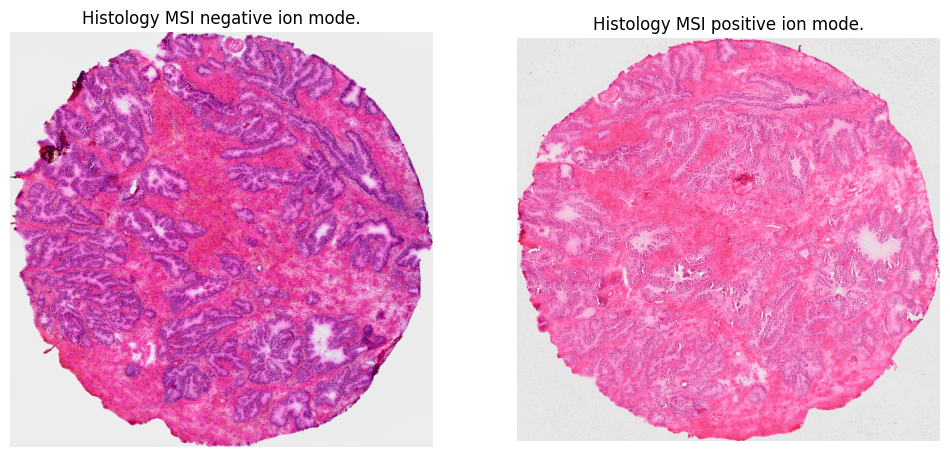

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(msi_pos_image.data)
axs[0].set_title('Histology MSI negative ion mode.')
axs[1].imshow(msi_neg_image.data)
axs[1].set_title('Histology MSI positive ion mode.')


### Registration

In [6]:
registerer = GreedyFHistExt.init_registerer(path_to_greedy='greedy')

transformation = registerer.register_images(
    moving_img=msi_neg_image.data,
    fixed_img=msi_pos_image.data
)

warped_msi_neg_image = msi_neg_image.apply_transform(registerer, transformation)
warped_imzml = imzml_neg.apply_transform(registerer, transformation)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Registered negative ion mode msi section')

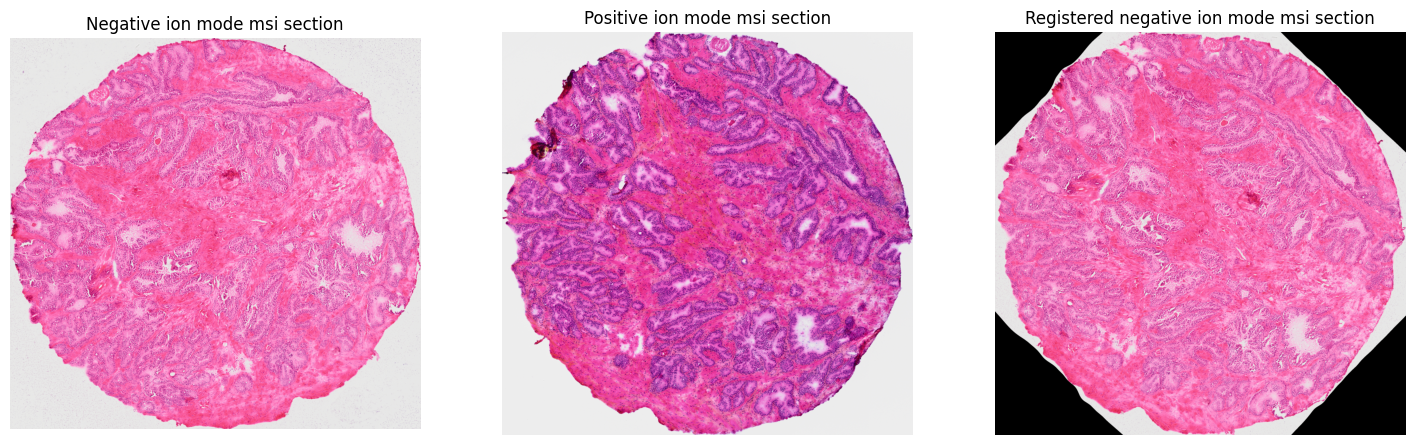

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(msi_neg_image.data)
axs[0].set_title('Negative ion mode msi section')
axs[1].imshow(msi_pos_image.data)
axs[1].set_title('Positive ion mode msi section')
axs[2].imshow(warped_msi_neg_image.data)
axs[2].set_title('Registered negative ion mode msi section')

###  Transformation from negative to positive ion mode msi

In [8]:
from miit.spatial_data.spatial_omics.imzml import (
    get_metabolite_intensities_targeted, 
    msi_default_accumulate_spot_weighted_mean, 
)
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts
)
from pyimzml.ImzMLParser import ImzMLParser

In [9]:
msi_pos_data = imzml_pos
msi_neg_data = warped_imzml
mappings, spots_background, unique_target_reference = get_mappings(msi_pos_data.ref_mat.data, msi_neg_data.ref_mat.data, msi_pos_data.background, msi_neg_data.background)

In [10]:
msi_pixel_idxs = msi_neg_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_neg_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_neg_data.config['imzml'])
msi_pos = ImzMLParser(msi_pos_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs)
metabolites_df.head()

,0,7,8,9,10,11,12,13,14,17,...,7701,7702,7703,7704,7705,7717,7718,7719,7720,7721
174.824,10.304942,10.615278,5.572582,7.135501,7.783841,4.963891,5.990486,6.466227,9.718613,8.080444,...,5.764295,7.101584,12.388509,11.580374,13.612533,7.297281,5.478263,11.758323,11.039879,16.471289
191.012,317.563293,159.688400,150.977448,78.432838,370.590790,248.621017,354.468475,401.162323,348.862854,333.250061,...,234.451324,251.028946,271.344391,272.052704,384.418945,286.125885,242.856522,290.694427,310.173950,339.678802


In [11]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, msi_neg_data)
integrated_df.head()

,174.824,191.012
7367,4.396881,353.038732
7371,5.543759,350.763381
7370,5.671953,363.902790
7356,3.837975,241.253587
7355,4.089812,142.078028


Similarly to the previous tutorial, we can map the integrated data onto the reference matrix format to get an image presentation. (Note the noise in the image data due to the random sampling.)

In [12]:
ion_images = msi_pos_data.to_ion_images(integrated_df.transpose())
labels = integrated_df.columns.to_list()

In [13]:
ion_images.labels = labels

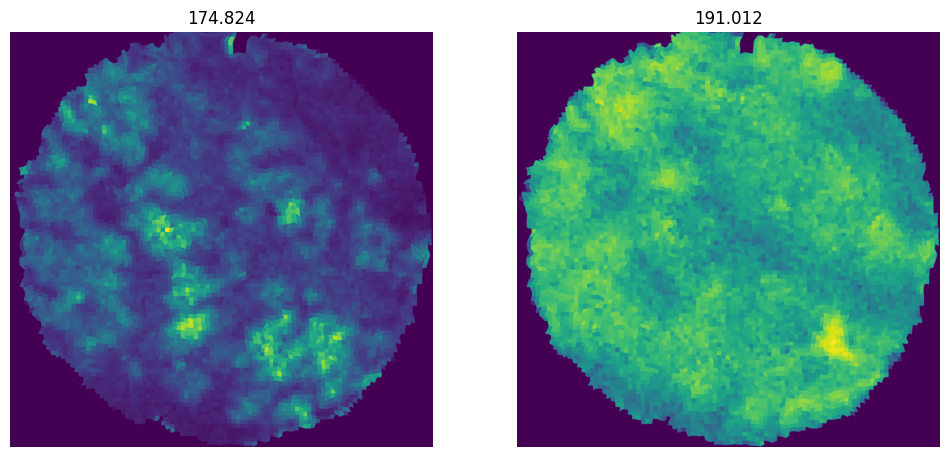

In [14]:
ion_images.plot_annotation()

### Export

For msi data, we can export data in the imzML format.

In [15]:
# Note that this function is still very experimental!
export_imzml(msi_pos, 'output_directory/integrated_msi_neg.imzML', integrated_df)